# MDP's

## Come up with 2 MDP problems
* Evironment guidlines
    * MDP 1 should have a small number of states
    * MDP 2 should have a large number of states
* Resources
    * https://gymnasium.farama.org/
    * https://github.com/Farama-Foundation/Gymnasium/tree/main/gymnasium/envs/toy_text

## Part 1: Solve each MDP using value iteration
    * http://www.incompleteideas.net/sutton/book/first/4/node5.html
    

## Part 2: Solve each MDP using policy iteration
    * http://www.incompleteideas.net/sutton/book/first/4/node4.html

## Part 3: Solve each MDP using a RL algorithm 
    * http://www.incompleteideas.net/sutton/book/first/6/node6.html
    * https://www.cs.cmu.edu/afs/cs/project/jair/pub/volume4/kaelbling96a-html/node29.html

**Analysis**
* problem introductions
    * Come up with two interesting MDPs
    * Explain why they are interesting.
    * it will be worthwhile if your MDPs are inspired by some 
      process you are interested in or are familiar with
    * It's ok to keep it somewhat simple.
    * no more than one of the MDPs you choose should be a so-called grid world problem
* part 1 and 2
    * How many iterations does it take to converge?
    * Which one converges faster?
    * Why might the faster converge that way?
    * How do you define convergence?
    * Do they converge to the same answers?
    * Was the number of states a contributor to performance differences?
        * Hypothesis: Larger take longer to converge
        * New hypothesis: longer episodes take longer to converge
* part 3
    * How does it perform compared to part 1 and 2
        * Consider how part 1 and 2 know the rewards, model, etc
    * What exploration strategies did you choose?
        * Compare different strategies and describe their performance

* Resources
    * [http://www.incompleteideas.net/sutton/book/first/4/node1.html] The term ``Dynamic Programming" (DP) refers to a collection of algorithms that can be used to compute optimal policies given a perfect model of the environment as a Markov decision process (MDP). Classical DP algorithms are of limited utility in reinforcement learning both because of their assumption of a perfect model and because of their great computational expense, but they are still very important theoretically. DP provides an essential foundation for the understanding of the methods presented in the rest of this book. In fact, all of these methods can be viewed as attempts to achieve much the same effect as DP, only with less computation and without assuming a perfect model of the environment.

## Experimentation

Analysis:


In [1]:
%load_ext autoreload
%autoreload 2

In [180]:
import gymnasium
import numpy as np
from matplotlib import pyplot as plt
from src.algorithms import policy_iteration, value_iteration, get_P_and_R, q_learning_w_dyna
from src.environments import get_s_frozen_lake, set_s_frozen_lake, get_s_size_frozen_lake, get_frozen_lake_win_ratio
from src.environments import get_s_blackjack, set_s_blackjack, get_s_size_blackjack, get_blackjack_win_ratio

### MDP 1: Frozen Lake

In [3]:
frozen_lake_kwargs = {
    "id": 'FrozenLake-v1',
    "map_name": "8x8",
    "is_slippery": True,
    "render_mode": "rgb_array"
    }
action_map = {0: "<", 1: "v", 2: ">", 3: "^"}

### MDP 2: Blackjack

* Found the odds of winning are 42.22%, so I want to get as close to this as possible
* Source: https://www.onlinegambling.com/blackjack/odds/

* After adjustments, the policy improved as more iterations were allowed, this was controlled by reducing the max delta parameter in the policy iteration algorithm
* However, the runtime has increased to 6 minutes to compute the policy. Adjusting to run the sampling in the transition matrix to run in parallel (any other opportunities? speed profile?)

In [4]:
blackjack_kwargs = {
    "id": 'Blackjack-v1',
    "render_mode": "rgb_array"
}

### Frozen Lake Prep

In [5]:
%%time

sample_size = 10_000
env = gymnasium.make(**frozen_lake_kwargs)
fl_P, fl_R = get_P_and_R(env, get_s_size_frozen_lake(), sample_size, set_s_frozen_lake)

CPU times: user 25.3 s, sys: 301 ms, total: 25.6 s
Wall time: 25.4 s


### Blackjack Prep

In [5]:
%%time

sample_size = 1000 # 10 takes 1 min, 100 takes 1.5 minutes
env = gymnasium.make(**blackjack_kwargs)
bj_P, bj_R = get_P_and_R(env, get_s_size_blackjack(), sample_size, set_s_blackjack)

CPU times: user 5min 40s, sys: 1.53 s, total: 5min 41s
Wall time: 5min 41s


## Part 1

### Policy Iteration: Frozen Lake

* converges even with max-delta=0

* gamma = 1.0 12 iterations, win ratio: 1.0  avg len: 113.9
* gamma = .75 9 iterations, win ratio: 0.637  avg len: 64.3
* gamma = .5 8 iterations, win ratio: 0.505  avg len: 54.2
* gamma = .25 8 iterations, win ratio: 0.061  avg len: 32.3
* gamma = .001 8 iterations, win ratio: 0.031  avg len: 25.4

Only gamma=1 is optimal. Why might this be? Low gamma policies aren't careful enough around the hazards. This could be due to the reward signal not coming through strongly enough. Creating an indifferent preference that is only generally correct. Clearly this will work sometimes since even with a very low gamma the agent has at least some success. This might also be due to the non-deterministic surface since at each step signal from the goal state is reduced further. The sum of the V array when gamma=1 is 43.22, while the sume when gamma=0.001 is only 0.673. The goal state is further away than the obstacles and the reward needs to be evenly represented with the closer obstacles. The temporal signal dissipates too much with a low gamma in combination with the small transition probabilities due to the lake's slippery surface. The higher gamma is required to allow the reward signal from the goal state to flow backwards throughout the environment. I'm still unsure though, as to why the agent wouldn't at least avoid the obstacles and lead to a longer average length. What I observed is the larger gamma leads to longer episodes and increased success rate. The larger gamma results in a policy that focuses on avoiding the obstacles and the relies on repeated steps to move to the goal instead of trying to take a step towards the goal directly (which will likely lead to an obstacle because of the slippery surface).

The optimal policy finds the path that completely avoids the obstacles even with the non-deterministic actions by pointing upward from the second row until the right side of the map is reached then the agent actions are only the move right. Eventually the agent can randomly reach the goal as the only possible direction to move is up or down and it will never leave the side of the map. This is interesting because even though the agent does not learn from experience the optimal policy can basically be computed and that includes a non-intuitive and smart policy. It is also interesting that the policy points right across the top row. It takes advantage of the extra space from the obstacles and finds a quicker route than to just rely on only random right or left moves. It figured out that it can take a step down and still always be able to recover by pointing up which will either take it left, right, or up, none of which would ever lead to an obstacle.

In [8]:
%%time

env = gymnasium.make(**frozen_lake_kwargs)
_, _, V, Pi = policy_iteration(env, set_s_frozen_lake, get_s_size_frozen_lake(), 
    gamma=1., max_delta = 0.0, max_iter = np.inf, sample_size=None, P=fl_P, R=fl_R)

iterations:  12
CPU times: user 513 ms, sys: 4.11 ms, total: 517 ms
Wall time: 515 ms


win ratio:  1.0  avg len: 113.9
[[' ^ ' ' > ' ' > ' ' > ' ' > ' ' > ' ' > ' ' > ']
 [' ^ ' ' ^ ' ' ^ ' ' ^ ' ' ^ ' ' ^ ' ' ^ ' ' > ']
 [' < ' ' < ' ' < ' ' < ' ' > ' ' ^ ' ' ^ ' ' > ']
 [' < ' ' < ' ' < ' ' v ' ' < ' ' < ' ' > ' ' > ']
 [' < ' ' ^ ' ' ^ ' ' < ' ' > ' ' v ' ' ^ ' ' > ']
 [' < ' ' < ' ' < ' ' v ' ' ^ ' ' < ' ' < ' ' > ']
 [' < ' ' < ' ' > ' ' ^ ' ' < ' ' < ' ' < ' ' > ']
 [' < ' ' v ' ' < ' ' < ' ' > ' ' > ' ' v ' ' < ']]


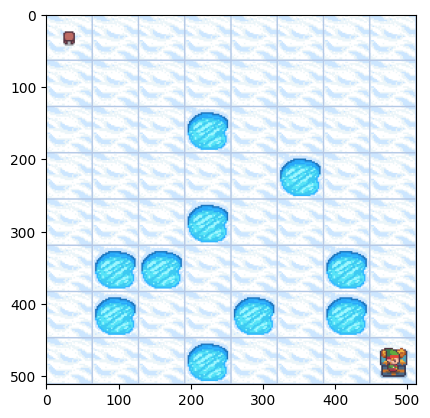

In [9]:
# Evaluate
win_ratio, avg_length = get_frozen_lake_win_ratio(env, Pi)
# Visualize policy
action_map = {0: " < ", 1: " v ", 2: " > ", 3: " ^ "}
print(np.array(list(map(action_map.get, Pi))).reshape((8, 8)))
plt.imshow(env.render())

### Policy Iteration: Blackjack
* changing from gamma=1.0 (35%) to gamma=0.001 (37%)
    * decreasing gamma somehow consistently improves the win rate
    * Why? 

    * gamma=1.0 5 iterations win ratio:  0.34149  hit hands:  178
    * gamma=0.75 2 iterations win ratio:  0.37774  hit hands:  145
    * gamma=0.5 2 iterations win ratio:  0.38098  hit hands:  168
    * gamma=0.25 1 iteration **best** win ratio:  0.38146  hit hands:  164
    * gamma=0.001 1 iteration win ratio:  0.35043  hit hands:  168

* converges with max-delta=0.0
* As gamma decreases it requires fewer iterations to converge
    * as gamma is increased, more information flows across time steps
* performance peaks from gamma between .25 and .5, since .25 only requires 1 iteration I would consider this optimal
* a single iteration took 235 ms

* when gamma=1.0 and no max_delta (inf) then the algorithm continues to run and doesn't converge
* I'm not sure I understand the relationship between gamma and the win ratio but I will try to think it through
    * A sequence consists of a starting hand and subsequent new cards added until the agent stays and the sequence ends with either a positive or negative reward
    * Hitting increases the sequence length and also increases the chance of a bust.
    * If gamma is small then more distant rewards will have less effect. 
    * A shorter term focus (lower gamma) would be heavily influenced by stays and busts which both end the game 
    * A longer term focus would be heavily influenced by busts and longer sequences would have more impact, suggesting a patience play focus when the player has a small hand
    * The reward signal is from a combination of these events and a slightly balanced gamma, from .5 to .25. results in the best policy. 

In [46]:
%%time 

env = gymnasium.make(**blackjack_kwargs)
_, _, V, Pi = policy_iteration(env, set_s_blackjack, get_s_size_blackjack(), 
    gamma=.25, max_delta = 1e-7, max_iter = 1000, sample_size=None, P=bj_P, R=bj_R)

iterations:  1
CPU times: user 223 ms, sys: 3.14 ms, total: 226 ms
Wall time: 223 ms


In [56]:
win_ratio = get_blackjack_win_ratio(env, Pi)

win ratio:  0.38278  hit hands:  164


## Part 2

### Value Iteration: Frozen Lake

* After using a higher max-delta (0.1) the policy converged in 4 iterations, however, the resulting policy produces an infinite loop. THere has to be enough iterations one per step required to reach the goal at a minimum. This is because on each iteration the next distance first receives reward signal from the goal state. States that have not yet been updated default to action 0 which causes the agent to continuously move left and if no obtacles are in the path against the left wall then it will run forever.
    * gamma=1.0 max-delta=0.01 68 iterations win ratio:  0.958  avg len: 101.2
    * gamma=.75, max_delta = 0.01 6 (infinite loop)
    * gamma=.5, max_delta = 0.01 4 iterations (infinite loop)

    * gamma=1.0 max_delta = 0.001 206 iterations win ratio:  1.0  avg len: 117.6 (best)
    * gamma=.75, max_delta = 0.001 11 iterations win ratio:  0.165  avg len: 45.7
    * gamma=.5, max_delta = 0.001 6 iterations (infinite loop) 

    * gamma=1.0, max_delta = 0.0001 332 iterations win ratio:  1.0  avg len: 119.1
    * gamma=.75, max_delta = 0.0001 17 iterations win ratio:  0.581  avg len: 61.5
    * gamma=.5, max_delta = 0.0001 9 iterations win ratio:  0.009  avg len: 76.5
    
* The best settings among those tested is a gamma=1.0 and max_delta=0.001 which takes 206 iterations to converge to the optimal policy.
* The number of iterations generally correlates with win ratio. An additional consideration is how quickly the agent can solve the puzzle, which could be a desirable behavior. 
    * V1: gamma=1 and max-delta=0.001 results in 117.6 average steps and 206 iterations
    * V2: gamma=1 and max-delta=0.0001 results in 119.1 average steps and 332 iterations
    * Even with more iterations, the second policy takes slightly longer on average than (are they even diff?)
    * The only tangible difference between the policies is in the first state (0) for v2 it goes up so only has a 33% chance of moving toward the goal
    * V1 goes down so it has a 33% chance of going down and a 33% chance of going right, a total of 66% chance of moving toward the goal

In [89]:
%%time

env = gymnasium.make(**frozen_lake_kwargs)
_, _, V, Pi = value_iteration(env, set_s_frozen_lake, get_s_size_frozen_lake(), 
    gamma=1.0, max_delta = 0.0001, max_iter = np.inf, sample_size=None, P=fl_P, R=fl_R)

iterations:  332
CPU times: user 332 ms, sys: 3.96 ms, total: 336 ms
Wall time: 331 ms


In [91]:
# Evaluate
win_ratio, avg_length = get_frozen_lake_win_ratio(env, Pi)
# Visualize policy
action_map = {0: " < ", 1: " v ", 2: " > ", 3: " ^ "}
print(np.array(list(map(action_map.get, Pi))).reshape((8, 8)))
env.reset()
# plt.imshow(env.render())


win ratio:  1.0  avg len: 116.2
[[' ^ ' ' > ' ' > ' ' > ' ' > ' ' > ' ' > ' ' > ']
 [' ^ ' ' ^ ' ' ^ ' ' ^ ' ' ^ ' ' ^ ' ' ^ ' ' > ']
 [' < ' ' < ' ' < ' ' < ' ' > ' ' ^ ' ' ^ ' ' > ']
 [' < ' ' < ' ' < ' ' v ' ' < ' ' < ' ' > ' ' > ']
 [' < ' ' ^ ' ' ^ ' ' < ' ' > ' ' v ' ' ^ ' ' > ']
 [' < ' ' < ' ' < ' ' v ' ' ^ ' ' < ' ' < ' ' > ']
 [' < ' ' < ' ' > ' ' ^ ' ' < ' ' < ' ' < ' ' > ']
 [' < ' ' v ' ' < ' ' < ' ' > ' ' > ' ' v ' ' < ']]


(0, {'prob': 1})

win ratio:  1.0  avg len: 115.6
[[' v ' ' > ' ' > ' ' > ' ' > ' ' > ' ' > ' ' > ']
 [' ^ ' ' ^ ' ' ^ ' ' ^ ' ' ^ ' ' ^ ' ' ^ ' ' > ']
 [' < ' ' ^ ' ' < ' ' < ' ' > ' ' ^ ' ' > ' ' > ']
 [' < ' ' < ' ' < ' ' v ' ' < ' ' < ' ' > ' ' > ']
 [' < ' ' ^ ' ' ^ ' ' < ' ' > ' ' v ' ' ^ ' ' > ']
 [' < ' ' < ' ' < ' ' v ' ' ^ ' ' < ' ' < ' ' > ']
 [' < ' ' < ' ' > ' ' ^ ' ' < ' ' < ' ' < ' ' > ']
 [' < ' ' v ' ' < ' ' < ' ' > ' ' > ' ' v ' ' < ']]


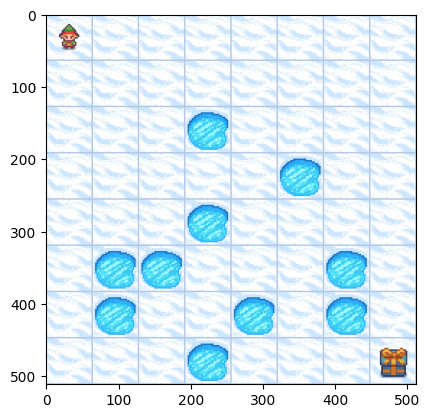

In [88]:
# Evaluate
win_ratio, avg_length = get_frozen_lake_win_ratio(env, Pi)
# Visualize policy
action_map = {0: " < ", 1: " v ", 2: " > ", 3: " ^ "}
print(np.array(list(map(action_map.get, Pi))).reshape((8, 8)))
env.reset()
plt.imshow(env.render())


### Value Iteration: Blackjack

* Experiments
    * gamma=1.0, max_delta=0.01, max_iter = 1000, 1000 iterations win ratio:  0.34479  hit hands:  177
    * gamma=.75, max_delta = 0.01, max_iter = 1000, 21 iterations  win ratio:  0.37801  hit hands:  145
    * gamma=.5, max_delta = 0.01, max_iter = 1000, 9 iterations win ratio:  0.38179  hit hands:  168 (best)
    * gamma=.25, max_delta = 0.01, max_iter = 1000, 5 iterations win ratio:  0.38149  hit hands:  164
    * gamma=.001, max_delta = 0.01, max_iter = 1000, 2 iterations win ratio:  0.34821  hit hands:  168

    * gamma=1.0, max_delta = 0.001, max_iter = 1000, 1000 iterations win ratio:  0.34227  hit hands:  177
    * gamma=.75, max_delta = 0.001, max_iter = 1000, 29 iterations win ratio:  0.37943  hit hands:  145
    * gamma=.5, max_delta = 0.001, max_iter = 1000, 12 iterations win ratio:  0.37854  hit hands:  168
    * gamma=.25, max_delta = 0.001, max_iter = 1000, 7 iterations win ratio:  0.38143  hit hands:  164

    * gamma=1.0, max_delta = 0.0001, max_iter = 1000, 1000 iterations win ratio:  0.34444  hit hands:  177
    * gamma=.75, max_delta = 0.0001, max_iter = 1000, 37 iterations win ratio:  0.37726  hit hands:  145
    * gamma=.5, max_delta = 0.0001, max_iter = 1000, 16 iterations win ratio:  0.37993  hit hands:  168
    * gamma=.25, max_delta = 0.0001, max_iter = 1000, 9 iterations win ratio:  0.37917  hit hands:  164

* Similar pattern emerges regarding gamma. The best gamma is between .5 and .25 indicating a balanced focus on short and near term leads to the best policy.
* When gamma=1 the algorithm takes much longer to converge and it isn't clear how many iterations are needed or if it ever converges. Even as the max_delta is decreased, making it easier to converge (in theory) it still runs over 1000 iterations.
* The best policy from Part 1 had 164 hit hands and from Part 2 has 168, indicating the policies are likely similar.
* Why does a higher gamma take longer to converge? 
    * Sequences in blackjack can be fairly long and the transition matrix is not as sparse as frozen lake.
    * Each time any state value is updated on an iteration, many state values are updated on the next iteration with new information.
    * The massive number of state connections result in a constant flow of reward information as the algorithm iterates.
    * When gamma is higher, the reward signal flow is stronger and this impacts more state values.
    * When gamma is lower, the reward signal does not reach as far backwards and takes less time to finish propagating.
    * When gamma is 1.0 then its not clear if the algorithm converges at all


In [134]:
%%time 

env = gymnasium.make(**blackjack_kwargs)
_, _, V, Pi = value_iteration(env, set_s_blackjack, get_s_size_blackjack(), 
   gamma=.5, max_delta = 0.01, max_iter = 1000, sample_size=None, P=bj_P, R=bj_R)

iterations:  9
CPU times: user 150 ms, sys: 3.41 ms, total: 154 ms
Wall time: 151 ms


In [135]:
win_ratio = get_blackjack_win_ratio(env, Pi)

win ratio:  0.38256  hit hands:  168


## Part 3

### Q-Learning: Frozen Lake

* Enough time must be given to explore or the algorithm will stop in a bad policy that often leads to infinite loops
    * When training or when evaluating, a bad policy will get stuck in an endless loop.
* For this smaller environment, Q-learning seems to be overkill. 
* Reward shaping is required for Q-learning to work with frozen lake when non-deterministic (deterministic not tested)
    * It is so tough to find the goal state that it can't randomly accomplish the goal when the only reward signal is from the goal state
    * I would add rewards that increasingly get bigger to avoid an infinite loop of exploiting rewards along the way to the goal
    * I tried creating a reward path to the goal, incrementing in reward on each step towards the goal so it doesn't exploit local rewards
    * Also set gamma high to focus on longer term rewards since it could take many steps to reach the goal
    * I tried penalizing time steps so it would try to get to the goal faster
    * I set alpha < 1 so it would handle the randomness well and not just learn the last example
    * Even while ensuring that there is enough exploration I still was unable to get the Q-learn algorithm to solve the frozen lake problem
* I think there is simply too much randomness? But even when not slippery it couldn't solve it.
* I tried reducing the problem size to 4x4 and the deterministic environment, still did not work even after 100K iterations
    * I tried increasing alpha and removing dyna, so it was now the classic Q-learning algorithm that updates online.
    * Running 1M iterations with a min epsilon of 0.05, so that when it does find 
    * What I think needs to happen is...
        * The agent must randomly stumble upon the goal state once
        * Then, before the reward signal has been erased from failed attempts, it must find the goal again, but this time it must use some of the reward signal from the original visit to get there in time.
        * Meanwhile, the epsilon must start to decay enough that it can begin to navigate itself by using the signal from the success.
        * If epsilon is too high then it will ignore the signal and take too many random actions, increasing the chance that the reward signal will vanish from the Q-table.
        * Therefore, there must be a perfect situation where the agent can randomly find the goal, then repeat the process by using the reward signal.
            * alpha can't be too high or the reward will be erased too quickly, but if its too low it will
            * Dyna could help with this by remembering successful episodes
        * The problem here is sparse rewards paired with longer episodes
* To finally solve:
    * First, debugged, made sure it would work for 4x4 deterministic since this is the easiest
        * Here I had to enable enough exploration before it started using the learned policy
    * Second, made the 4x4 slippery
        * The alpha parameter (now that I'm using mixing to avoid overflow) must be sufficiently small
    * Third, moved to 8x8 non-slippery
        * This required reward shaping to solve as the probability of randomly reaching the goal is very very small (won't even both to calculate)
    * Fourth, moved to 8x8 slippery
        * Now able to create a non-optimal policy that sometimes solves it
        * Requires tons of iterations, so I will try to use hydra to make better use of the experience
    * Now the algorithm can find the optimal policy, but it does not do so on a consistent basis. The results range from 0% win rate to 100%. Some modifications I could make could be to perform experience replay only on successful episodes once it's able to find the goal. However, this solution does not generalize well to problems that are only partionally observable since hidden variables may maintain different values, for example the blackjack problem.
    * Even after setting the reward for the goal state to be 100, unable to find optimal policy
    * Sometimes it is close to an optimal policy except that instead of moving along the right wall, such as the policy and value iteration algorithms did, it moves to the left, preventing it from reaching the goal. Perhaps it is trying to exploit the rewards from reward shaping, so I tried adding a step penalty in hopes this would encourage it to find the larger reward and end the episode, however this does not work well and it finds other variations that are non-optimal.
    * I believe that with enough experimentation, the agent could eventually find the optimal policy, however, considering that in depth knowledge of the environment was required to reward shape, and that the parameters require hand tuning, the Q-learning algorithm does not seem to be a good choice for this problem. The main issue is the sparse rewards and the other is the low probability from randomly finding the goal. From there, great care must be taken to properly select prior experience to learn from in order to find the optimal policy.

In [232]:
# Reward shaping is required for Q-learning to discover how to reach the goal state
reward_shaping = np.zeros(shape=(get_s_size_frozen_lake(), ), dtype=np.float32)
reward_shaping[0:7] = np.array([0, 1, 2, 3, 4, 5, 6])
reward_shaping[[(8 * i)-1 for i in range(1, 9)]] = np.array(range(7, 15))
reward_shaping[-1] = 100
reward_shaping.reshape((8, 8))

array([[  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   8.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   9.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  10.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  11.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  12.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  13.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., 100.]], dtype=float32)

In [276]:
env = gymnasium.make(**frozen_lake_kwargs)
Q, Pi = q_learning_w_dyna(env, get_s=get_s_frozen_lake, state_size=get_s_size_frozen_lake(), 
    n_episodes = 10_000, epsilon = 1.0, epsilon_decay = .9995,
    min_epsilon = 0.0, dyna = None, dyna_period = None,
    alpha=.0001, gamma=1.0, reward_shaping=reward_shaping, penalize_step=True)

final epsilon: 0.00673  successful episodes: 813/10000


In [277]:
# Visualize policy
action_map = {0: " < ", 1: " v ", 2: " > ", 3: " ^ "}
print(np.array(list(map(action_map.get, Pi))).reshape((8, 8)))

[[' ^ ' ' ^ ' ' ^ ' ' ^ ' ' ^ ' ' ^ ' ' ^ ' ' < ']
 [' > ' ' ^ ' ' ^ ' ' > ' ' > ' ' < ' ' > ' ' > ']
 [' v ' ' ^ ' ' v ' ' < ' ' < ' ' > ' ' ^ ' ' v ']
 [' > ' ' > ' ' v ' ' ^ ' ' > ' ' < ' ' ^ ' ' > ']
 [' < ' ' > ' ' < ' ' < ' ' < ' ' ^ ' ' v ' ' > ']
 [' < ' ' < ' ' < ' ' < ' ' ^ ' ' ^ ' ' < ' ' > ']
 [' < ' ' < ' ' ^ ' ' v ' ' < ' ' < ' ' < ' ' < ']
 [' ^ ' ' > ' ' < ' ' < ' ' ^ ' ' ^ ' ' v ' ' < ']]


In [278]:
# Evaluate
win_ratio, avg_length = get_frozen_lake_win_ratio(env, Pi)


win ratio:  0.251  avg len: 230.6


### Q-Learning: Blackjack

* Performed better with > 0 min-epsilon
* produced 100K episodes
* every 1000 episodes, 500 random example tuples are used to update the Q table
* epsilon starts at 1.0 and has a gradual decay of 1 - 1e-5
* This ensures that exploration is slowly reduced after more updates are made to the Q table
* Exploration/exploitation tradeoff of Q-learning
    * too low of decay results in a slightly worse final policy
    * when starting at 1 and stopping at .37 the win ratio was consistently > .4
    
* n_episodes = 100_000, epsilon = 1.0, epsilon_decay = 0.9999, alpha=.0001, gamma=1.0, min_epsilon = 0.0, dyna = None, dyna_period = None: (win ratio:  0.42029  hit hands:  175)
    * surprisingly this seems to have found an optimal or near optimal policy achieving win ratios > 42% which I thought wasn't possible, most likely if this was ran over and over it would average out to ~42%. I did, however, run the simiulation 5 times and each time it results in >42% win probability which is quite impressive.

* This problem does not have the problem of sparse rewards and it also has shorter episodes. Lending to a better environment for Q-learning.
* Fairly robust to any gamma. From 0.01 to 1.0 it was still able to find a policy > 41% win rate consistently
* Alpha needed to be sufficiently small. 0.01 produced <38% win rate while 0.0001 produced a near optimal policy.
* epsilon was allowed to decay evenly toward zero without a minimum, the final epsilon value was 0.00005 indicating the last number of episodes are controlled completely by the agent.

In [294]:
env = gymnasium.make(**blackjack_kwargs)
Q, Pi = q_learning_w_dyna(env, get_s=get_s_blackjack, state_size=get_s_size_blackjack(), 
    n_episodes = 100_000, epsilon = 1.0, epsilon_decay = 0.9999,
    alpha=.0001, gamma=1.0, min_epsilon = 0.0, dyna = None, dyna_period = None)
win_ratio = get_blackjack_win_ratio(env, Pi)

final epsilon: 0.00005  successful episodes: 40505/100000
win ratio:  0.42029  hit hands:  175
